In [65]:
from src.params import Params
from src.output import Outputs
from src.channel_simulation import *

import numpy as np

# Channel Simulation
here starts the actual channel simulator code.

we will demonstrate the following block diagram


In [66]:
class BlockDiagram:
  """
msg -> [modulation] -> [oversample + pulse-shape] -> [pre-equalize] -> [INFT] ⤵
                                                                          [channel]
msg <- [Demodulation]  <-   [   match-filter   ]  <-  [equalize]    <- [NFT]  /
  """

In [67]:
p = Params(m_qam = 16,
           num_symbols = 512,
           normalization_factor = 10,
           plot_vec_after_creation=True)
o = Outputs()
np.set_printoptions(threshold=250)

## 0) Generate message

In [68]:
o.x[0] = Step0.generate_message(p)


_______________________________________________
message before channel - len=2048
[[1 1 0 1]
 [1 1 1 0]
 [1 0 0 1]
 ...
 [1 1 0 0]
 [0 0 1 1]
 [0 0 1 0]]




## 1) Modulation


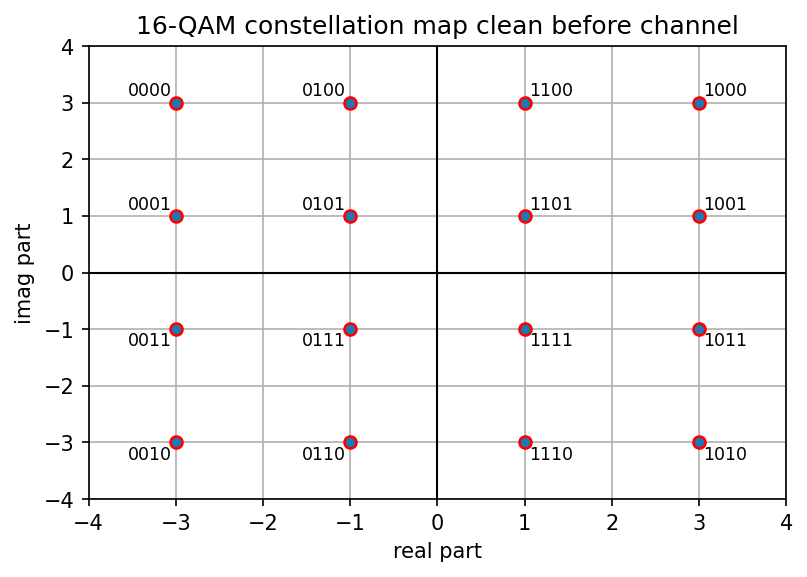

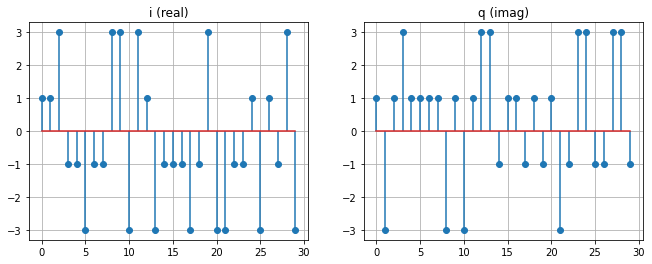

num of symbols = 512


In [69]:
o.x[1], o.modem = Step1.modulate(o.x[0],p)

### 1.1) Test demod

In [70]:
x0_reconst = o.modem.demodulate(o.x[1])
num_errors = (x0_reconst != o.x[0]).sum()
if p.plot_vec_after_creation:
    Visualizer.print_bits(x0_reconst, p.sps, 'test reconstructed msg')
    Visualizer.print_bits(o.x[0], p.sps, 'message before channel')
    print(f'ber = {num_errors/p.length_of_msg} = {num_errors}/{p.length_of_msg}')


_______________________________________________
test reconstructed msg - len=2048
[[1 1 0 1]
 [1 1 1 0]
 [1 0 0 1]
 ...
 [1 1 0 0]
 [0 0 1 1]
 [0 0 1 0]]



_______________________________________________
message before channel - len=2048
[[1 1 0 1]
 [1 1 1 0]
 [1 0 0 1]
 ...
 [1 1 0 0]
 [0 0 1 1]
 [0 0 1 0]]


ber = 0.0 = 0/2048


## 2) over sampling
over sample a vector by factor, using zero padding in between each sample

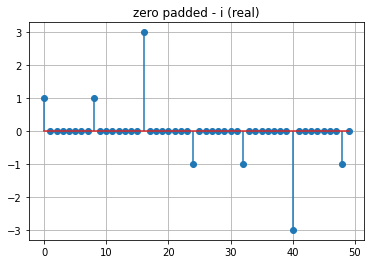

vec length = 4089, over_sampling period = 8


In [71]:
o.x[2] = Step2.over_sample(o.x[1],p)

## 3) Pulse Shaping
* convolve with filter: rrc
* fliter length is chosen such that x afterwards will be length power of two (closest above)

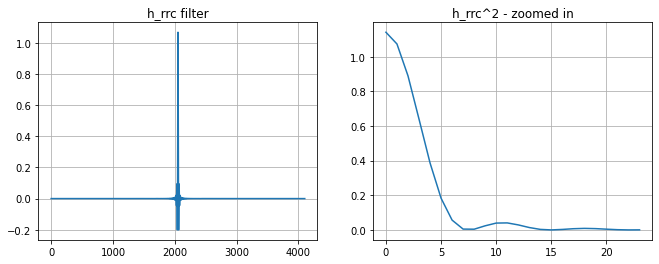

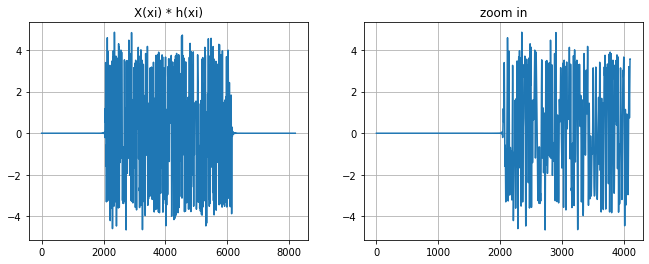

filter len = 4104, signal len = 8192


In [72]:
o.x[3], o.h_rrc, o.L_rrc = Step3.pulse_shape(o.x[2],p)

### 3.1 Test: reconstruction
before we move on, lets try to restore this using match filter


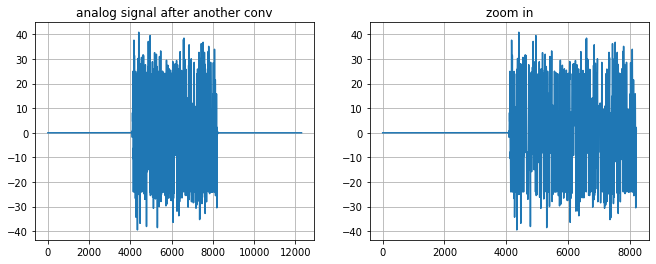

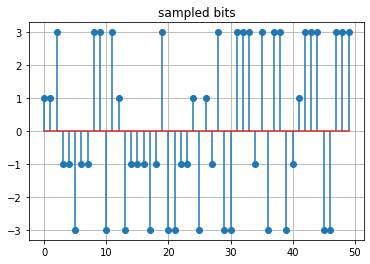

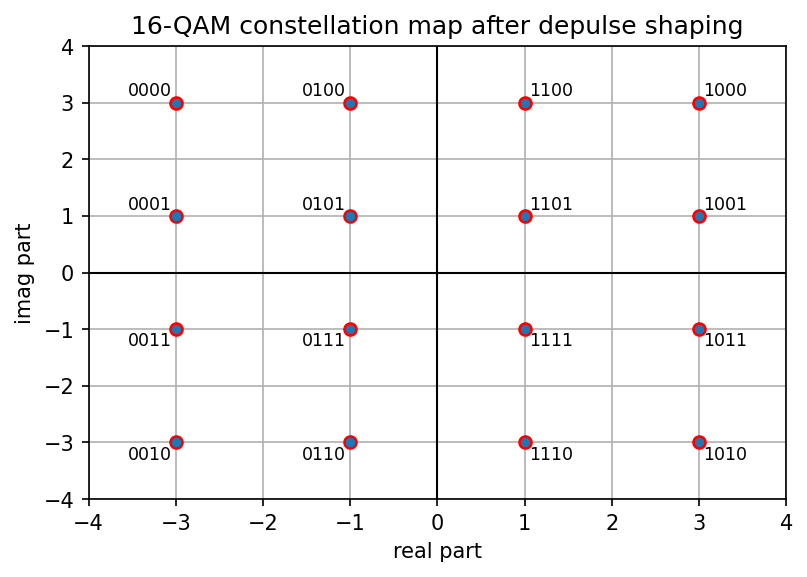

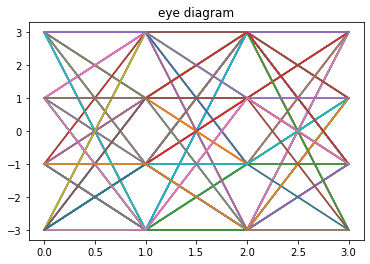

In [73]:
xx41 = np.convolve(o.x[3], o.h_rrc)

# sampling the analog vector into discrete bits
L_rrc = len(o.h_rrc)
start = L_rrc
stop = - L_rrc + p.over_sampling
step = p.over_sampling
xx42 = xx41[start:stop:step]/p.over_sampling

if p.plot_vec_after_creation:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
    Visualizer.my_plot(np.real(xx41),name='analog signal after another conv',ax=ax1,hold=1)
    Visualizer.my_plot(np.real(xx41[:L_rrc*2]),name='zoom in',ax=ax2)

    Visualizer.my_plot(np.real(xx42[0:50]),name='sampled bits',function='stem')

    Visualizer.plot_constellation_map_with_points(xx42, p.m_qam, 'after depulse shaping')
    Visualizer.eye_diagram(xx42, sps=p.sps)


## 4) Pre-Equalizer
*   normalize




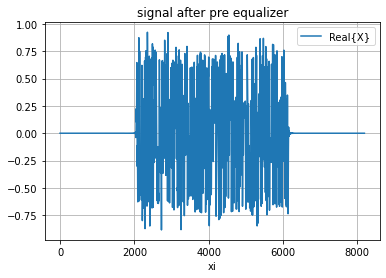

signal len = 8192


In [98]:
p.normalization_factor = 0.1
o.x[4] = Step4.pre_equalize(o.x[3], p)

## 5) INFT

FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


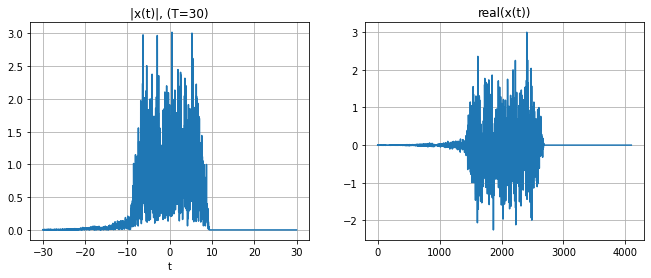

length of INFT(x) = 4096


In [99]:
Step5.add_nft_params(o.x[4],p,o)
o.x[5] = Step5.inft(o.x[4],p,o)

## 6) Channel 
  (nothing)

In [76]:
o.x[6] = Step6.channel(o.x[5],p)

## 7) NFT

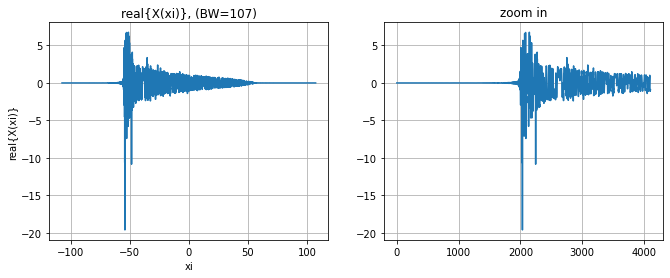

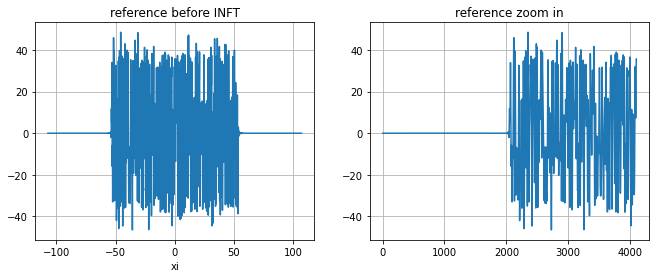

In [77]:
o.x[7] = Step7.nft(o.x[6],p,o)

## 8) Equalizer


*   de-normalize
*   channel equalizer (nothing)



In [78]:
o.x[8] = Step8.equalizer(o.x[7],p)

## 9) Match Filter
convolve again with the rrc filter and sample at the over sampling period

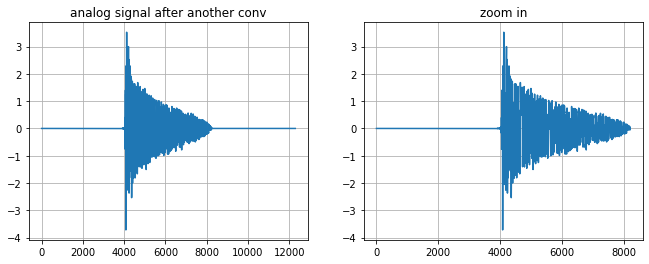

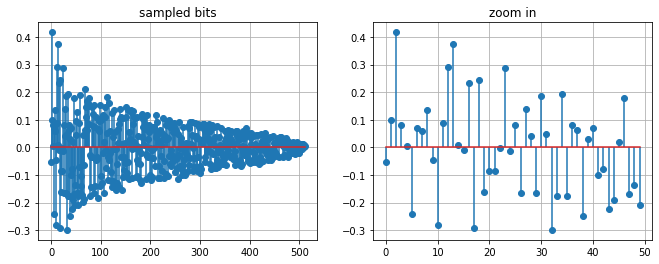

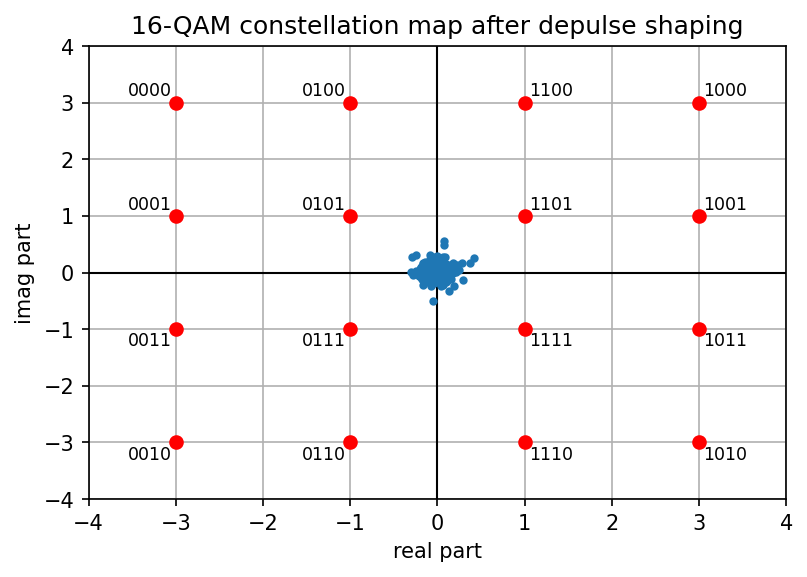

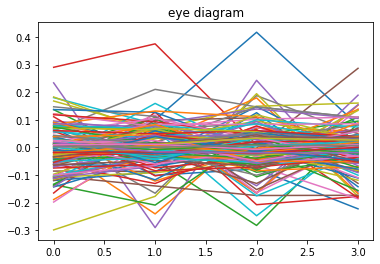

In [79]:
o.x[9] = Step9.match_filter(o.x[8],p,o)

## 10) Demodulation

In [80]:
o.x[10], ber, _ = Step10.demodulate(o.x[9],p,o,o.x[0],o.modem)


_______________________________________________
message after channel - len=2048
[[0 1 0 1]
 [1 1 1 1]
 [1 1 0 1]
 ...
 [1 1 1 1]
 [1 1 0 1]
 [1 1 1 1]]


ber = 0.50830078125 = 1041/2048
